# **🎵 AUDIO EMOTION CLASSIFICATION USING NEURAL NETWORK**

---



<I><h1>Imports and Initial setup</h2>

In [54]:
import os
import glob
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import traceback
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<I><h3>Filename identifiers<h3>
<ol>
<li>Modality (01 = full-AV, 02 = video-only, 03 = audio-only).</li>
<li>Vocal channel (01 = speech, 02 = song).</li>
<li>Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).</li>
<li>Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.</li>
<li>Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").</li>
<li>Repetition (01 = 1st repetition, 02 = 2nd repetition).</li>
<li>Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).</li>


<I><h1>Features Extraction & Loading</h1>

In [56]:
# Speech & Song file path
speech_path = '/content/drive/My Drive/Mars_dataset/Audio_Speech_Actors_01-24'
song_path = '/content/drive/My Drive/Mars_dataset/Audio_Song_Actors_01-24'

In [57]:
# Emotion mapping
EMOTION_MAP = {
    '01': 'neutral', '02': 'calm', '03': 'happy',
    '04': 'sad', '05': 'angry', '06': 'fearful',
    '07': 'disgust', '08': 'surprised'
}

In [69]:
def extract_mfcc(y, sr):
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs, axis=1)
    return mfccs

In [58]:
#Audio Augmentation
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sr, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr, pitch_factor)

def augment_audio(y, sr):
    augmented = []
    for factor in [-2, 2]:
        try:
            y_pitch = pitch(y, sr, pitch_factor=factor)
            augmented.append(y_pitch)
        except: pass
    for rate in [0.8, 1.2]:
        try:
            y_stretch = stretch(y, rate)
            augmented.append(y_stretch)
        except: pass
    try:
        augmented.append(shift(y))
        augmented.append(noise(y))
    except: pass
    return augmented

In [59]:
def load_data(data_dir):
    file_paths = []
    labels = []
    for actor_dir in os.listdir(data_dir):
        actor_path = os.path.join(data_dir, actor_dir)
        if not os.path.isdir(actor_path):
            continue
        for file in os.listdir(actor_path):
            if file.endswith('.wav'):
                file_path = os.path.join(actor_path, file)
                try:
                    emotion_code = file.split('-')[2]
                    emotion = EMOTION_MAP[emotion_code]
                    file_paths.append(file_path)
                    labels.append(emotion)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return file_paths, labels

In [60]:
file_paths_speech, labels_speech = load_data(speech_path)

In [61]:
file_paths_song, labels_song = load_data(song_path)

In [62]:
file_paths = file_paths_speech + file_paths_song
labels = labels_speech + labels_song

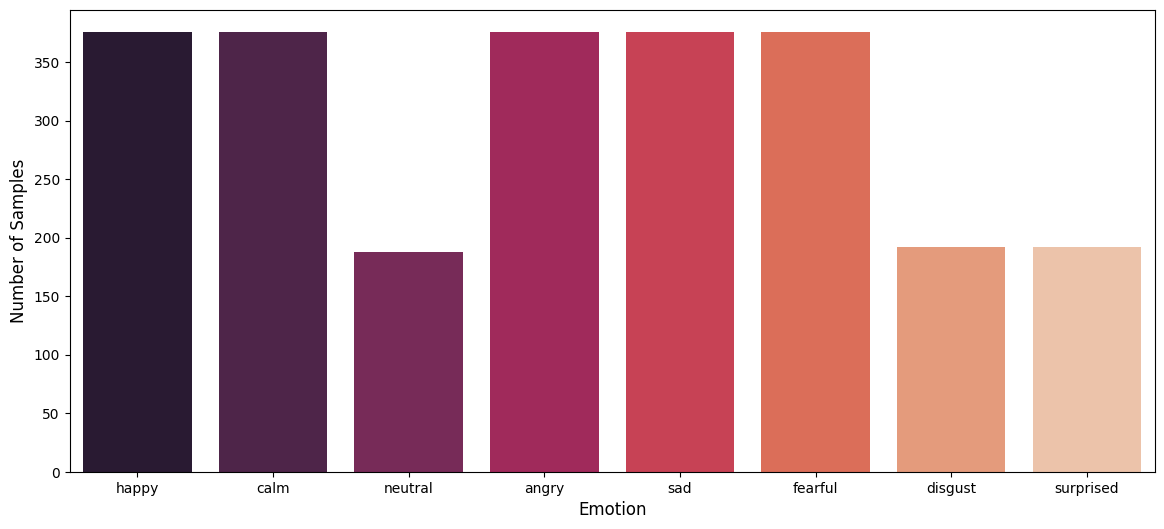

In [63]:
plt.figure(figsize=(14,6))
sns.countplot(x=labels, palette='rocket', hue=labels, legend=False)
plt.xlabel('Emotion',fontsize=12)
plt.ylabel('Number of Samples',fontsize=12)
plt.show()
# print(len(file_paths))
# print(len(labels))

In [64]:
X_train_paths, X_test_paths, y_train_labels, y_test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [65]:
print(f"Training samples: {len(X_train_paths)}")
print(f"Testing samples: {len(X_test_paths)}")

Training samples: 1961
Testing samples: 491


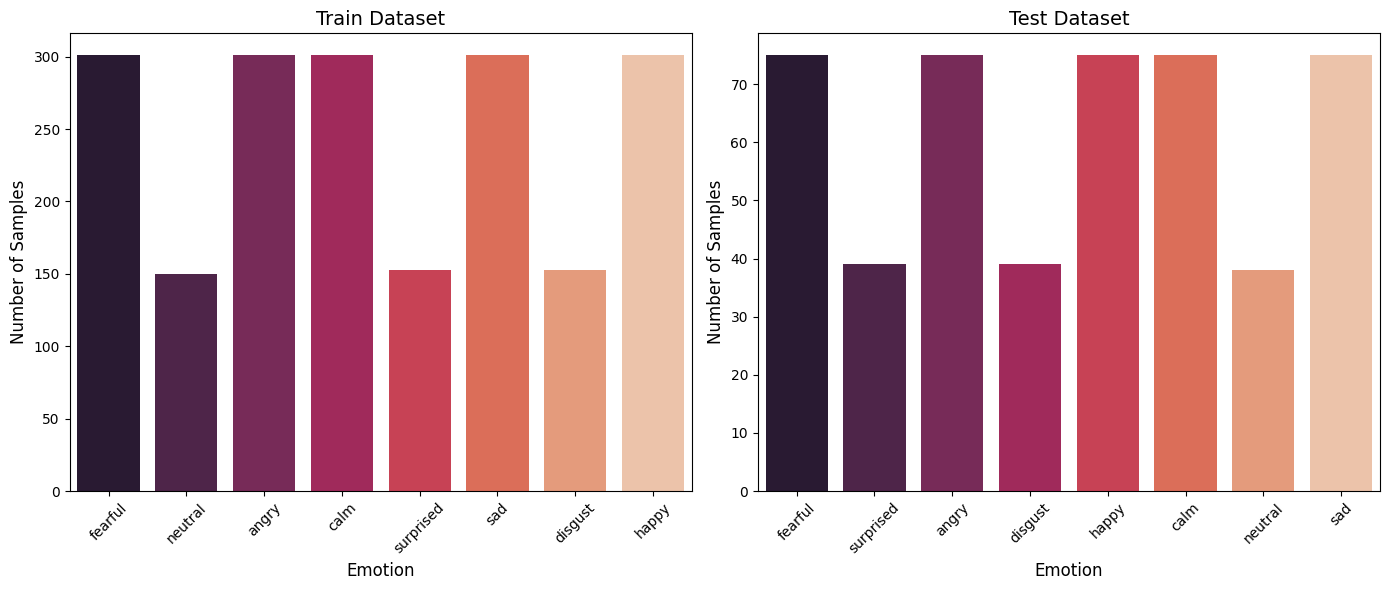

In [67]:
plt.figure(figsize=(14,6))
# Subplot 1: Speech
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_labels, palette='rocket', hue=y_train_labels, legend=False)
plt.title("Train Dataset", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)


# Subplot 2: Song
plt.subplot(1, 2, 2)
sns.countplot(x=y_test_labels, palette='rocket', hue=y_test_labels, legend=False)
plt.title("Test Dataset", fontsize=14)
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [68]:
from collections import Counter

# Count label frequency in training data
class_counts = Counter(y_train_labels)
max_count = max(class_counts.values())

print(class_counts)

Counter({'fearful': 301, 'angry': 301, 'calm': 301, 'sad': 301, 'happy': 301, 'surprised': 153, 'disgust': 153, 'neutral': 150})


In [70]:
X_train = []
y_train = []

underrepresented_labels = {'neutral', 'disgust', 'surprised'}

print("Extracting training features...")
for file_path, label in tqdm(zip(X_train_paths, y_train_labels), total=len(X_train_paths)):
    try:
        y, sr = librosa.load(file_path, sr=22050)

        # Always include the original sample
        mfcc = extract_mfcc(y, sr)
        X_train.append(mfcc)
        y_train.append(label)

        # For underrepresented classes, also add augmentations
        if label in underrepresented_labels:
            augmented_data = augment_audio(y, sr)
            for augmented in augmented_data:
                features_aug = extract_mfcc(augmented, sr)
                X_train.append(features_aug)
                y_train.append(label)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        traceback.print_exc()

Extracting training features...


100%|██████████| 1961/1961 [01:24<00:00, 23.22it/s]


In [71]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(f"Training samples: {X_train.shape[0]}, features: {X_train.shape[1]};")
print(f"Training labels: {y_train.shape[0]}")
print(X_train.shape)

Training samples: 2873, features: 40;
Training labels: 2873
(2873, 40)


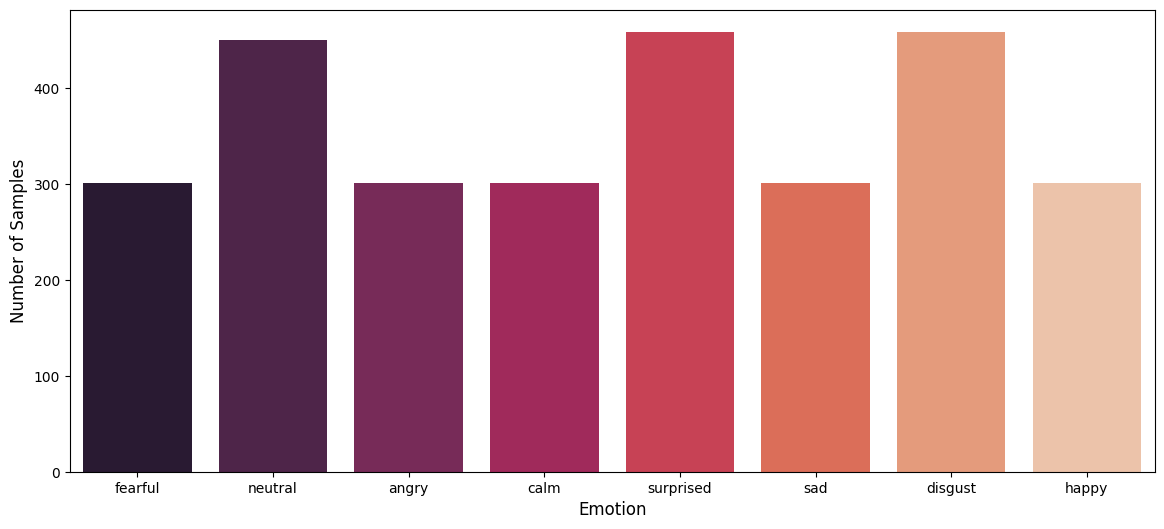

In [72]:
plt.figure(figsize=(14,6))
sns.countplot(x=y_train, palette='rocket', hue=y_train, legend=False)
plt.xlabel('Emotion',fontsize=12)
plt.ylabel('Number of Samples',fontsize=12)
plt.show()

In [73]:
X_test = []
y_test = []

for file_path, label in tqdm(zip(X_test_paths, y_test_labels), total=len(X_test_paths)):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        ftr = extract_mfcc(y, sr)
        X_test.append(ftr)
        y_test.append(label)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


100%|██████████| 491/491 [00:24<00:00, 19.95it/s]


In [74]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print(f"Test samples: {X_test.shape[0]}, features: {X_test.shape[1]};")
print(f"Test labels: {y_test.shape[0]}")
print(X_test.shape)

Test samples: 491, features: 40;
Test labels: 491
(491, 40)


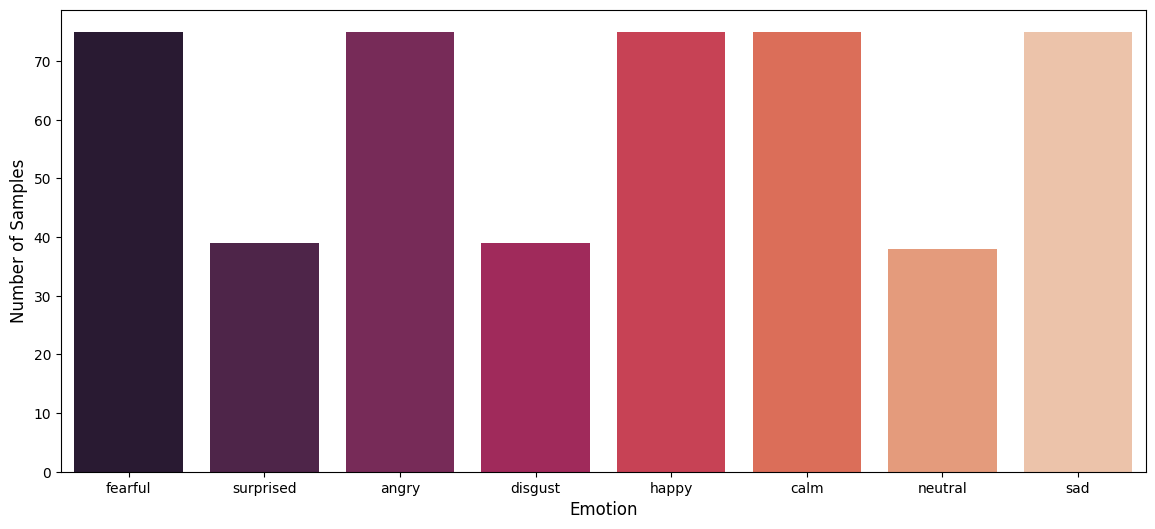

In [75]:
plt.figure(figsize=(14,6))
sns.countplot(x=y_test, palette='rocket', hue=y_test, legend=False)
plt.xlabel('Emotion',fontsize=12)
plt.ylabel('Number of Samples',fontsize=12)
plt.show()

In [76]:
#Saving the extracted features
# joblib.dump((X_train, y_train), "/content/drive/MyDrive/Mars_dataset/train_datasetaugmented.joblib")
# joblib.dump((X_test, y_test), "/content/drive/MyDrive/Mars_dataset/test_dataset.joblib")

['/content/drive/MyDrive/Mars_dataset/test_dataset_193.joblib']

Loading the dataset

In [77]:
# X_train, y_train = joblib.load("/content/drive/MyDrive/Mars_dataset/train_dataset_augmented.joblib")
# X_test, y_test = joblib.load("/content/drive/MyDrive/Mars_dataset/test_dataset.joblib")

In [79]:
from collections import Counter
print(Counter(y_train))

Counter({np.str_('surprised'): 459, np.str_('disgust'): 459, np.str_('neutral'): 450, np.str_('fearful'): 301, np.str_('angry'): 301, np.str_('calm'): 301, np.str_('sad'): 301, np.str_('happy'): 301})


<i>
<h2>DATA PREPROCESSING</h2>

In [80]:
# Encode emotion labels
le = LabelEncoder()
y_train_enc = (le.fit_transform(y_train))
y_test_enc = (le.transform(y_test))
joblib.dump(le, "/content/drive/MyDrive/Mars_dataset/label_encoder.pkl")


# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "/content/drive/MyDrive/Mars_dataset/s_scaler.pkl")

['/content/drive/MyDrive/Mars_dataset/s_scaler.pkl']

<I>
<h2>MODEL TRAINING

MLP CLASSIFIER

In [81]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model_mlp = MLPClassifier(
    random_state = 42
)

In [82]:
model_mlp.fit(X_train_scaled, y_train_enc)

print(f'Possible emotions predicted by model:{model_mlp.classes_}')
print(f'MLP Model\'s accuracy on training set is {100*model_mlp.score(X_train_scaled, y_train_enc):.2f}%')
print(f'MLP Model\'s accuracy on test set is {100*model_mlp.score(X_test_scaled, y_test_enc):.2f}%')

Possible emotions predicted by model:[0 1 2 3 4 5 6 7]
MLP Model's accuracy on training set is 98.22%
MLP Model's accuracy on test set is 73.93%


DENSE NEURAL NETWORK

In [83]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(EMOTION_MAP), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5),
    ModelCheckpoint(filepath='/content/drive/MyDrive/Mars_dataset/emotion_model.h5', save_best_only=True)
]

history = model.fit(
    X_train_scaled, y_train_enc,
    validation_data=(X_test_scaled, y_test_enc),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,832 (741.53 KB)

 Trainable params: 188,040 (734.53 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2081 - loss: 2.5176

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.2097 - loss: 2.5103 - val_accuracy: 0.3585 - val_loss: 1.7624 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4172 - loss: 1.6822

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.4174 - loss: 1.6806 - val_accuracy: 0.4318 - val_loss: 1.6152 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4711 - loss: 1.4456

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.4713 - loss: 1.4454 - val_accuracy: 0.4338 - val_loss: 1.4919 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5088 - loss: 1.3383

45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.5090 - loss: 1.3377 - val_accuracy: 0.4969 - val_loss: 1.3749 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5663 - loss: 1.2050

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.5662 - loss: 1.2048 - val_accuracy: 0.5153 - val_loss: 1.2601 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5734 - loss: 1.1777

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.5734 - loss: 1.1775 - val_accuracy: 0.5601 - val_loss: 1.1578 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5904 - loss: 1.0763

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.5907 - loss: 1.0759 - val_accuracy: 0.6008 - val_loss: 1.0743 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6360 - loss: 1.0051

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.6359 - loss: 1.0051 - val_accuracy: 0.6334 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6337 - loss: 0.9692

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.6337 - loss: 0.9692 - val_accuracy: 0.6375 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6557 - loss: 0.9337

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.6557 - loss: 0.9335 - val_accuracy: 0.6395 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6673 - loss: 0.8925

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.6672 - loss: 0.8929 - val_accuracy: 0.6701 - val_loss: 0.9171 - learning_rate: 0.0010
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6664 - loss: 0.8700

45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.6666 - loss: 0.8701 - val_accuracy: 0.6843 - val_loss: 0.8828 - learning_rate: 0.0010
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7123 - loss: 0.8038

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.7120 - loss: 0.8044 - val_accuracy: 0.6904 - val_loss: 0.8624 - learning_rate: 0.0010
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7151 - loss: 0.7665

45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.7149 - loss: 0.7675 - val_accuracy: 0.7149 - val_loss: 0.8367 - learning_rate: 0.0010
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7341 - loss: 0.7736

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.7338 - loss: 0.7737 - val_accuracy: 0.7189 - val_loss: 0.8083 - learning_rate: 0.0010
Epoch 16/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.7148 - loss: 0.7655 - val_accuracy: 0.7026 - val_loss: 0.8400 - learning_rate: 0.0010
Epoch 17/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.7262 - loss: 0.7225 - val_accuracy: 0.7006 - val_loss: 0.8098 - learning_rate: 0.0010
Epoch 18/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.7357 - loss: 0.7176 - val_accuracy: 0.7088 - val_loss: 0.8262 - learning_rate: 0.0010
Epoch 19/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7465 - loss: 0.6889

45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.7464 - loss: 0.6891 - val_accuracy: 0.7230 - val_loss: 0.7644 - learning_rate: 0.0010
Epoch 20/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.7586 - loss: 0.6713 - val_accuracy: 0.7413 - val_loss: 0.7801 - learning_rate: 0.0010
Epoch 21/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7445 - loss: 0.6741

45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.7443 - loss: 0.6741 - val_accuracy: 0.7576 - val_loss: 0.7604 - learning_rate: 0.0010
Epoch 22/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7697 - loss: 0.6465

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.7696 - loss: 0.6463 - val_accuracy: 0.7576 - val_loss: 0.7145 - learning_rate: 0.0010
Epoch 23/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.7652 - loss: 0.6405 - val_accuracy: 0.7495 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 24/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.7828 - loss: 0.5892 - val_accuracy: 0.7536 - val_loss: 0.7253 - learning_rate: 0.0010
Epoch 25/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.7945 - loss: 0.5528 - val_accuracy: 0.7556 - val_loss: 0.7466 - learning_rate: 0.0010
Epoch 26/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.7919 - loss: 0.5422 - val_accuracy: 0.7434 - val_loss: 0.7391 - learning_rate: 0.0010
Epoch 27/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.8108 - loss: 0.5325 - val_accuracy: 0.7475 - val_loss: 0.7294 - learning_rate: 0.0010
Epoch 28/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8274 - loss: 0.5073

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8271 - loss: 0.5077 - val_accuracy: 0.7739 - val_loss: 0.6823 - learning_rate: 2.0000e-04
Epoch 29/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8268 - loss: 0.5061

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.8267 - loss: 0.5060 - val_accuracy: 0.7699 - val_loss: 0.6740 - learning_rate: 2.0000e-04
Epoch 30/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8193 - loss: 0.4990

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.8194 - loss: 0.4985 - val_accuracy: 0.7780 - val_loss: 0.6667 - learning_rate: 2.0000e-04
Epoch 31/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8220 - loss: 0.4733

45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.8220 - loss: 0.4737 - val_accuracy: 0.7719 - val_loss: 0.6620 - learning_rate: 2.0000e-04
Epoch 32/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8295 - loss: 0.4648

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.8295 - loss: 0.4646 - val_accuracy: 0.7739 - val_loss: 0.6574 - learning_rate: 2.0000e-04
Epoch 33/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8302 - loss: 0.4725

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.8302 - loss: 0.4724 - val_accuracy: 0.7780 - val_loss: 0.6512 - learning_rate: 2.0000e-04
Epoch 34/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.8305 - loss: 0.4598 - val_accuracy: 0.7862 - val_loss: 0.6516 - learning_rate: 2.0000e-04
Epoch 35/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.8317 - loss: 0.4640 - val_accuracy: 0.7882 - val_loss: 0.6563 - learning_rate: 2.0000e-04
Epoch 36/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.8460 - loss: 0.4386 - val_accuracy: 0.7780 - val_loss: 0.6569 - learning_rate: 2.0000e-04
Epoch 37/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.8488 - loss: 0.4391 - val_accuracy: 0.7719 - val_loss: 0.6591 - learning_rate: 2.0000e-04
Epoch 38/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8478 - loss: 0.4451

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.8478 - loss: 0.4450 - val_accuracy: 0.7841 - val_loss: 0.6485 - learning_rate: 2.0000e-04
Epoch 39/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8328 - loss: 0.4454

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.8330 - loss: 0.4454 - val_accuracy: 0.7841 - val_loss: 0.6380 - learning_rate: 2.0000e-04
Epoch 40/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.8458 - loss: 0.4492 - val_accuracy: 0.7800 - val_loss: 0.6463 - learning_rate: 2.0000e-04
Epoch 41/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.8492 - loss: 0.4279 - val_accuracy: 0.7882 - val_loss: 0.6394 - learning_rate: 2.0000e-04
Epoch 42/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.8318 - loss: 0.4385 - val_accuracy: 0.7943 - val_loss: 0.6382 - learning_rate: 2.0000e-04
Epoch 43/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.8439 - loss: 0.4249 - val_accuracy: 0.7862 - val_loss: 0.6430 - learning_rate: 2.0000e-04
Epoch 44/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8541 - loss: 0.4182

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8542 - loss: 0.4179 - val_accuracy: 0.7923 - val_loss: 0.6286 - learning_rate: 2.0000e-04
Epoch 45/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8579 - loss: 0.3982

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8581 - loss: 0.3980 - val_accuracy: 0.7923 - val_loss: 0.6266 - learning_rate: 2.0000e-04
Epoch 46/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.8590 - loss: 0.3957 - val_accuracy: 0.7862 - val_loss: 0.6350 - learning_rate: 2.0000e-04
Epoch 47/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8565 - loss: 0.4088

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8564 - loss: 0.4088 - val_accuracy: 0.8024 - val_loss: 0.6163 - learning_rate: 2.0000e-04
Epoch 48/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8545 - loss: 0.3901

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.8545 - loss: 0.3902 - val_accuracy: 0.7984 - val_loss: 0.6085 - learning_rate: 2.0000e-04
Epoch 49/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8409 - loss: 0.4200

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.8411 - loss: 0.4198 - val_accuracy: 0.8086 - val_loss: 0.6015 - learning_rate: 2.0000e-04
Epoch 50/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.8542 - loss: 0.4174 - val_accuracy: 0.8024 - val_loss: 0.6090 - learning_rate: 2.0000e-04
Epoch 51/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.8633 - loss: 0.3808 - val_accuracy: 0.7984 - val_loss: 0.6253 - learning_rate: 2.0000e-04
Epoch 52/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.8785 - loss: 0.3572 - val_accuracy: 0.8045 - val_loss: 0.6137 - learning_rate: 2.0000e-04
Epoch 53/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.8722 - loss: 0.3401 - val_accuracy: 0.8004 - val_loss: 0.6086 - learning_rate: 2.0000e-04
Epoch 54/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.8463 - loss: 0.4104 - val_accuracy: 0.8024 - val_loss: 0.6054 - learning_rate: 2.0000e-04
Epoch 55/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accur

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8088 - loss: 0.5825
Validation Accuracy: 80.86%


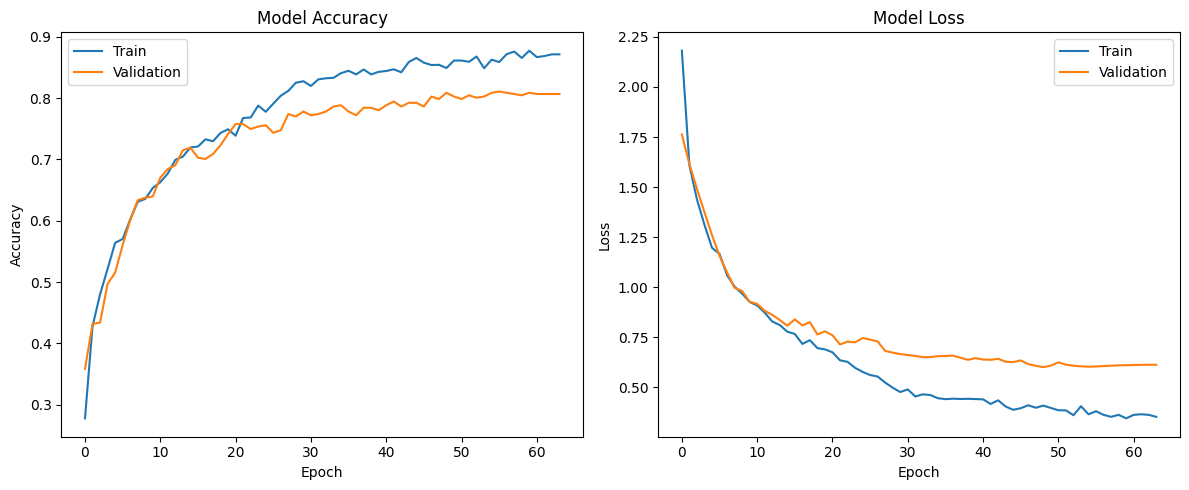

In [84]:
# Evaluate performance
val_loss, val_acc = model.evaluate(X_test_scaled, y_test_enc)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Overall Accuracy: 80.86%
Macro-average F1 Score: 0.8006

Classification Report:
               precision    recall  f1-score   support

       angry     0.8701    0.8933    0.8816        75
        calm     0.8507    0.7600    0.8028        75
     disgust     0.7021    0.8462    0.7674        39
     fearful     0.8205    0.8533    0.8366        75
       happy     0.8852    0.7200    0.7941        75
     neutral     0.7083    0.8947    0.7907        38
         sad     0.8082    0.7867    0.7973        75
   surprised     0.7250    0.7436    0.7342        39

    accuracy                         0.8086       491
   macro avg     0.7963    0.8122    0.8006       491
weighted avg     0.8150    0.8086    0.8086       491



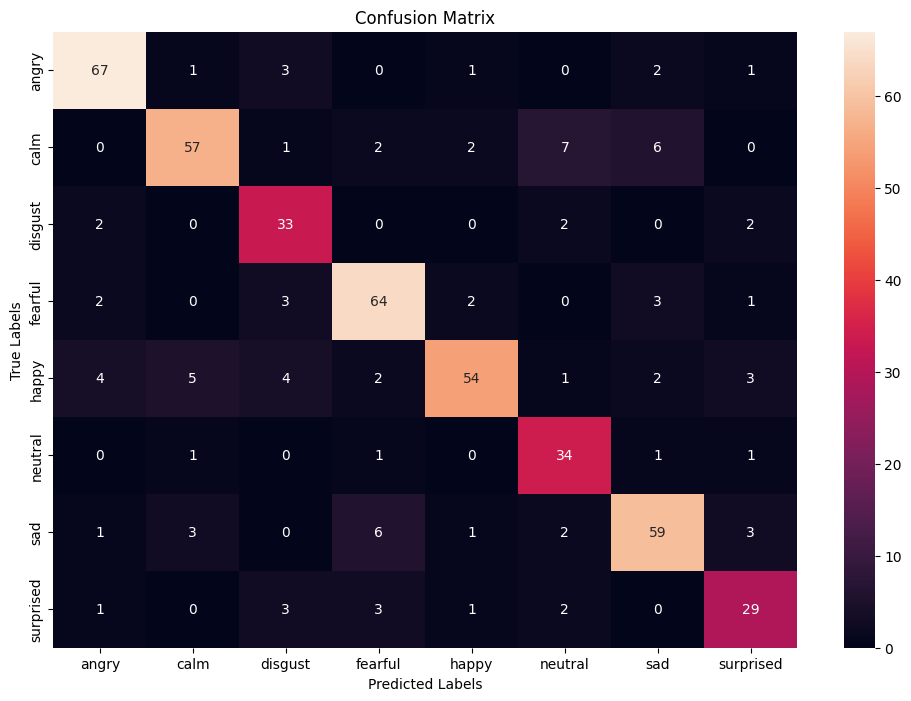

In [85]:
# Predict classes and probabilities
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Overall accuracy
accuracy = accuracy_score(y_test_enc, y_pred_classes)
print(f"Overall Accuracy: {accuracy*100:.2f}%")

# F1 scores (macro average)
f1 = f1_score(y_test_enc, y_pred_classes, average='macro')
print(f"Macro-average F1 Score: {f1:.4f}")

# Detailed classification report
report = classification_report(
    y_test_enc,
    y_pred_classes,
    target_names=le.classes_,
    digits=4
)
print("\nClassification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)

# Visualize with seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()